<a href="https://colab.research.google.com/github/s-yuflih/spasia/blob/main/geology/geological_mapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install geemap earthengine-api tensorflow scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.0 MB/s eta 0:00:00


In [1]:
import ee
import geemap
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib
import matplotlib.patches as mpatches

# 1. INITIALIZATION & SETUP

* Trigger GEE authentication.
* If this is your first time running this, a browser window will open for auth.
* Please replace 'your-earthengine-project-id' with your actual Google Cloud Project ID.
* You can find your Project ID at https://console.cloud.google.com/ in the top navigation bar.

In [18]:
# IMPORTANT: Replace 'your-earthengine-project-id' with your actual Google Cloud Project ID.
# For example: ee.Initialize(project='your-earthengine-project-id')
PROJECT_ID = 'your-earthengine-project-id'

try:
    ee.Initialize(project= 'xenon-effect-471904-b3')
except Exception:
    ee.Authenticate()
    ee.Initialize(project= 'xenon-effect-471904-b3')

# Define the Coordinate
# (Longitude, Latitude)
center_point = ee.Geometry.Point([137.11424413257282,-4.055925419629327])

# Create Square Bounds (5000m "radius" -> 10000m x 10000m box)
roi = center_point.buffer(5000).bounds()

print("Initializing Geological Mapping for ROI...")

Initializing Geological Mapping for ROI...


# 2. SENTINEL-2 PROCESSING (Structural & Iron Oxides)

In [19]:
def mask_s2_clouds(image):
    """Masks clouds in Sentinel-2 utilizing the QA60 band."""
    qa = image.select('QA60')
    cloud_bit_mask = 1 << 10
    cirrus_bit_mask = 1 << 11
    mask = qa.bitwiseAnd(cloud_bit_mask).eq(0).And(
           qa.bitwiseAnd(cirrus_bit_mask).eq(0))
    return image.updateMask(mask).divide(10000)

# Filter Sentinel-2 Collection
# We use the Harmonized Sentinel-2 L2A collection for surface reflectance
s2_col = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
          .filterBounds(roi)
          .filterDate('2020-01-01', '2025-12-31')
          .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
          .map(mask_s2_clouds))

# Check if the ASTER collection is empty
num_s2_features = s2_col.size().getInfo()
print(f"Number of SENTINEL-2 images found: {num_s2_features}")

# Create a median composite to remove transient noise
s2_image = s2_col.median().clip(roi)

# --- Land/Water Masking ---
# Calculate NDWI: (Green - NIR) / (Green + NIR)
# Sentinel-2 Green band is B3, NIR band is B8
ndwi = s2_image.normalizedDifference(['B3', 'B8']).rename('NDWI')
# Land mask: where NDWI is less than 0 (water generally has NDWI > 0)
land_mask = ndwi.lt(0).selfMask()

# Apply land mask to the S2 image
s2_image = s2_image.updateMask(land_mask)
# --------------------------------------------------

# Iron Oxide (Gossan) Ratio: B4 (Red) / B2 (Blue)
iron_oxide_idx = s2_image.expression(
    'B4 / B2',
    {'B4': s2_image.select('B4'), 'B2': s2_image.select('B2')}
).rename('Iron_Oxide_S2')

# Ferrous Iron Ratio: B12 / B8 (SWIR2 / NIR)
# Used to map mafic minerals
ferrous_iron_idx = s2_image.expression(
    'B12 / B8',
    {'B12': s2_image.select('B12'), 'B8': s2_image.select('B8')}
).rename('Ferrous_Iron_S2')

# Clay (Argillic) Ratio: B11 / B12 (SWIR1 / SWIR2)
clay_idx = s2_image.expression(
    'B11 / B12',
    {'B11': s2_image.select('B11'), 'B12': s2_image.select('B12')}
).rename('Clay_S2')

Number of SENTINEL-2 images found: 535


# 3. ASTER PROCESSING (Detailed Mineralogy)

* **CRITICAL: Filtering 2000-2008 because SWIR sensor failed in April 2008.**
* Use ASTER L1T (Radiance) for ratios.
* Note: Ideally we use Crosstalk Corrected (AST_07XT), but L1T is more widely accessible in the public catalog for script portability.

In [20]:
# We perform simple atmospheric adjustment by using dark object subtraction implicitly via ratios.
aster_col = (ee.ImageCollection('ASTER/AST_L1T_003')
             .filterBounds(roi)
             .filterDate('2000-01-01', '2008-04-01') # Strict date filter per report
             .filter(ee.Filter.lt('CLOUDCOVER', 10))
             .select(['B01', 'B02', 'B3N', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09']))

# Check if the ASTER collection is empty
num_aster_features = aster_col.size().getInfo()
print(f"Number of ASTER images found: {num_aster_features}")

if num_aster_features == 0:
    print("Warning: No ASTER images found for the specified ROI, date range, and cloud cover. Skipping ASTER processing and visualization.")
    aster_image = None # Set to None to indicate no ASTER data
    kaolinite_idx = None
    alunite_idx = None
    propylitic_idx = None
else:
    aster_image = aster_col.median().clip(roi)
    # Apply the same land mask to ASTER image if it exists
    aster_image = aster_image.updateMask(land_mask) # Apply land mask to ASTER image

    def dos_correction(image):
        corrected_bands = []
        for band_name in image.bandNames().getInfo():
            band = image.select(band_name)
            # Calculate the minimum pixel value (dark object) in the ROI
            min_dict = band.reduceRegion(
                reducer=ee.Reducer.min(),
                geometry=roi,
                scale=30, # Use a reasonable scale for calculation
                maxPixels=1e9
            )
            min_val = ee.Number(min_dict.get(band_name))

            # Subtract the dark object value from the band
            corrected_band = band.subtract(min_val).rename(band_name)
            corrected_bands.append(corrected_band)

        # Combine all corrected bands into a new image
        return ee.Image(corrected_bands)

    print("Applying Dark Object Subtraction (DOS) to ASTER image...")
    aster_image_dos = dos_correction(aster_image)

    # --- ASTER Indices (Advanced ASTER Mineral Indices) ---

    # Kaolinite Index (KAI): B4 / B6
    # Target: Al-OH absorption at 2.20um (Band 6) vs background (Band 4)
    kaolinite_idx = aster_image_dos.expression(
        'b("B04") / b("B06")',
        {'B04': aster_image_dos.select('B04'), 'B06': aster_image_dos.select('B06')}
    ).rename('Kaolinite_ASTER')

    # Alunite Index (ALUI): (B5 + B7) / B6
    # Target: Distinct absorption in B5 vs Kaolinite
    alunite_idx = aster_image_dos.expression(
        '(b("B05") + b("B07")) / b("B06")',
        {'B05': aster_image_dos.select('B05'), 'B07': aster_image_dos.select('B07'), 'B06': aster_image_dos.select('B06')}
    ).rename('Alunite_ASTER')

    # Propylitic / Mg-OH Index: B6 / B9
    # Target: Chlorite/Epidote absorption at 2.39um (Band 9)
    propylitic_idx = aster_image_dos.expression(
        'b("B06") / b("B09")',
        {'B06': aster_image_dos.select('B06'), 'B09': aster_image_dos.select('B09')}
    ).rename('Propylitic_ASTER')


Number of ASTER images found: 14
Applying Dark Object Subtraction (DOS) to ASTER image...


# 4. VISUALIZATION & MAP GENERATION

In [21]:
# Get the coordinates from center_point and reverse them for geemap (geemap expects [latitude, longitude])
map_center_coords = center_point.coordinates().getInfo()
map_center = [map_center_coords[1], map_center_coords[0]]

# Create the Map
Map = geemap.Map(center=map_center, zoom=13, basemap='SATELLITE')

# 1. Base Layer: Sentinel-2 True Color
Map.addLayer(s2_image,
             {'min': 0, 'max': 0.3, 'bands': ['B4', 'B3', 'B2']},
             'S2 True Color (Reference)')

# 2. Sentinel-2 Structural Map
# High-resolution (10m) Band 8 is ideal for mapping lineaments and faults.
# We render this in grayscale to serve as a high-contrast base for the ASTER mineral overlays.
Map.addLayer(s2_image,
             {'min': 0, 'max': 0.3, 'bands': ['B8'], 'palette': ['black', 'white']},
             'S2 Structural Base (10m)', shown= False)

# 3. Sentinel-2 "Geology / Alteration" FCC (Section 3.3)
# RGB: B12 (SWIR2), B11 (SWIR1), B2 (Blue)
# Interpretation: Hydrothermal clays appear Teal/Cyan; Iron oxides appear dark.
Map.addLayer(s2_image,
             {'min': 0, 'max': 0.4, 'bands': ['B12', 'B11', 'B2']},
             'S2 Alteration FCC (B12-B11-B2)', shown= False)

# 4. Sentinel-2 Iron Oxide Index (Heatmap)
# High values (Red/Yellow) = High Iron Oxide content
Map.addLayer(iron_oxide_idx,
             {'min': 1, 'max': 3, 'palette': ['blue', 'white', 'yellow', 'red']},
             'S2 Iron Oxide Index', shown= False)

# Add ASTER layers only if data is available
if aster_image is not None:
    # 5. ASTER "Standard Alteration" FCC (Section 3.2)
    # RGB: B4, B6, B8
    # Interpretation: Kaolinite = Reddish; Propylitic = Greenish
    Map.addLayer(aster_image_dos,
                 {'min': 0, 'max': 255, 'bands': ['B04', 'B06', 'B08'], 'gamma': 1.5},
                 'ASTER Std Alteration FCC (4-6-8)', shown= False)

    # 6. ASTER Mineral Indices (Masked for clarity)
    # Only showing high probability pixels (threshold > mean + sigma approx)
    Map.addLayer(kaolinite_idx.updateMask(kaolinite_idx.gt(1.1)),
                 {'min': 1.1, 'max': 2.0, 'palette': ['yellow', 'red']},
                 'ASTER Kaolinite', shown= False)

    Map.addLayer(alunite_idx.updateMask(alunite_idx.gt(1.1)),
                 {'min': 1.1, 'max': 2., 'palette': ['red', 'cyan']},
                 'ASTER Alunite', shown= False)

    Map.addLayer(propylitic_idx.updateMask(propylitic_idx.gt(1.05)),
                 {'min': 1.05, 'max': 1.5, 'palette': ['cyan', 'green']},
                 'ASTER Propylitic', shown= False)

# Add ROI outline
Map.addLayer(ee.Image().paint(roi, 0, 2), {'palette': 'red'}, 'ROI')

# Add Layer Control
Map.add_layer_control()

Map

Map(center=[38.290353546000816, -110.06342948070517], controls=(WidgetControl(options=['position', 'transparen…

# 5. RANDOM FOREST (RF) CLASSIFICATION: HYBRID DATA FUSION

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from matplotlib.patches import Patch
from scipy.ndimage import binary_opening

In [9]:
# --- Safety Check ---
required_vars = ['s2_image', 'roi', 'iron_oxide_idx', 'clay_idx']
if any(var not in globals() for var in required_vars):
    raise ValueError("Missing variables! Please run Sections 1-3 first.")

print("Constructing Optimal Data Cube (GEE Side)...")

# --- 4.1 Construct the "Data Cube" ---

# 1. Topography
dem = ee.Image('USGS/SRTMGL1_003').clip(roi)
slope = ee.Terrain.slope(dem)

# 2. Textural Features (FIXED: Cast to Int for GLCM)
# We multiply by 10000 to preserve data precision before casting to Integer
texture_input = s2_image.select('B8').multiply(10000).toInt()
texture = texture_input.glcmTexture(size=1)
texture_bands = texture.select(['B8_contrast', 'B8_ent'])

# 3. Spectral Bands (Sentinel-2 + Optional ASTER)
# IMPORTANT: B2(Blue)=0, B3(Green)=1, B4(Red)=2 in the stack for RGB visualization later
fused_bands = s2_image.select(['B2', 'B3', 'B4', 'B8', 'B11', 'B12'])

if 'aster_image' in globals() and aster_image is not None:
    print("Fusing ASTER SWIR bands...")
    fused_bands = fused_bands.addBands(aster_image.select(['B04', 'B05', 'B06', 'B07', 'B08', 'B09']))

# 4. Band Ratios
fused_bands = fused_bands.addBands([
    iron_oxide_idx.rename('Iron_Ratio'),
    clay_idx.rename('Clay_Ratio')
])

# 5. Final Stack
data_cube = fused_bands.addBands([
    dem.rename('Elevation'),
    slope.rename('Slope')
]).addBands(texture_bands)


# --- 4.2 Prepare Weak Labels ---
# Class 0: Host Rock (Background), 1: Iron Oxide, 2: Clay
labels = ee.Image.constant(0).rename('class')
labels = labels.where(iron_oxide_idx.gt(1.8), 1)

if 'kaolinite_idx' in globals() and kaolinite_idx is not None:
    labels = labels.where(kaolinite_idx.gt(1.15), 2)
else:
    labels = labels.where(clay_idx.gt(1.5), 2)

export_stack = data_cube.addBands(labels)


# --- 4.3 Hybrid Workflow: Export & Train ---
print("Exporting Analysis-Ready Chips...")

try:
    # Use scale=30m for a balance of resolution and speed
    arr = geemap.ee_to_numpy(export_stack, region=roi, scale=30)

    if arr is None:
        raise ValueError("Export failed (Result is None).")

    print(f"Data fetched. Shape: {arr.shape}")
    h, w, c = arr.shape

    # Separate Features and Labels
    X_raw = arr[:, :, :-1].reshape((-1, c-1))
    y_raw = arr[:, :, -1].reshape((-1))

    # Mask NaNs
    valid_mask = np.isfinite(X_raw).all(axis=1)
    X = X_raw[valid_mask]
    y = y_raw[valid_mask]

    print(f"Training RF on {X.shape[0]} pixels...")

    # Train/Test Split: Split data before training the model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    rf_model = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)
    rf_model.fit(X_train, y_train) # Fit the model on the training data

    # Validate
    rf_accuracy = rf_model.score(X_test, y_test)
    print(f"RF Accuracy: {rf_accuracy:.2f}")

except Exception as e:
    print(f"Error: {e}")
    print("Tip: If you see memory errors, try increasing scale to 50 or 100.")

Constructing Optimal Data Cube (GEE Side)...
Fusing ASTER SWIR bands...
Exporting Analysis-Ready Chips...
Data fetched. Shape: (335, 333, 19)
Training RF on 111555 pixels...
RF Accuracy: 0.97


## MAP GENERATION

Applying Morphological Filter to Clean Noise...
Generating Comparative Analysis (For Reference)...


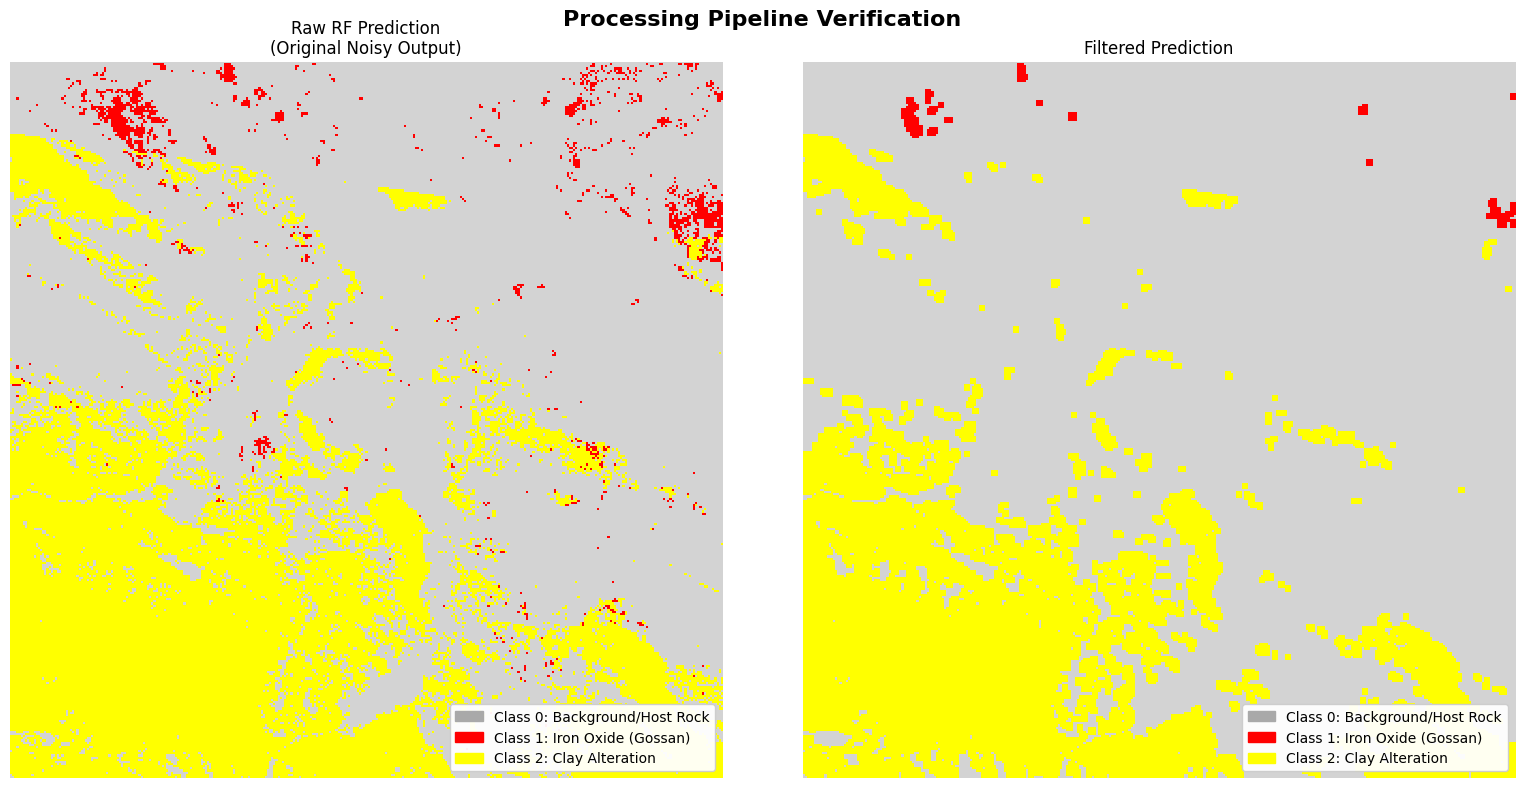

In [10]:
    # Predict entire map (Raw Result)
    full_prediction = np.zeros(y_raw.shape)
    full_prediction[valid_mask] = rf_model.predict(X) # Predict on all valid data
    class_map = full_prediction.reshape((h, w))

    # APPLY POST-PROCESSING (FILTERING) ---

    print("Applying Morphological Filter to Clean Noise...")

    # Filter: Morphological Opening (Removes small 'salt-and-pepper' noise)
    # 1. Clean Iron (Class 1)
    clean_iron = binary_opening(class_map == 1, structure=np.ones((3,3))).astype(int)
    # 2. Clean Clay (Class 2)
    clean_clay = binary_opening(class_map == 2, structure=np.ones((3,3))).astype(int)

    # Reconstruct Cleaned Map (This will be used for the Aesthetic Overlay)
    clean_map = np.zeros_like(class_map)
    clean_map[clean_iron == 1] = 1
    clean_map[clean_clay == 1] = 2

    # COMPARATIVE ANALYSIS (Raw vs Cleaned)

    print("Generating Comparative Analysis (For Reference)...")

    fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)

    # Define custom colormap and legend elements
    colors = ['lightgray', 'red', 'yellow'] # 0: Background, 1: Iron Oxide, 2: Clay Alteration
    cmap = matplotlib.colors.ListedColormap(colors)
    bounds = [-0.5, 0.5, 1.5, 2.5] # Boundaries for each class
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

    legend_patches = [
        mpatches.Patch(color='darkgray', label='Class 0: Background/Host Rock'),
        mpatches.Patch(color='red', label='Class 1: Iron Oxide (Gossan)'),
        mpatches.Patch(color='yellow', label='Class 2: Clay Alteration')
    ]

    # Raw Prediction
    axes[0].imshow(class_map, cmap=cmap, norm=norm, interpolation='nearest')
    axes[0].set_title("Raw RF Prediction\n(Original Noisy Output)", fontsize=12)
    axes[0].axis('off')
    axes[0].legend(handles=legend_patches, loc='lower right', frameon=True, facecolor='white', framealpha=0.95)

    # Filtered Prediction
    axes[1].imshow(clean_map, cmap=cmap, norm=norm, interpolation='nearest')
    axes[1].set_title("Filtered Prediction", fontsize=12)
    axes[1].axis('off')
    axes[1].legend(handles=legend_patches, loc='lower right', frameon=True, facecolor='white', framealpha=0.95)

    plt.suptitle("Processing Pipeline Verification", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# 6. DEEP LEARNING WORKFLOW: HYBRID MODEL (CNN + SVM)
## Architecture: Input Patch -> VGG16 (Feature Extractor) -> Deep Features -> SVM Classifier

In [11]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.svm import SVC

In [12]:
print("Starting Hybrid Workflow (CNN + SVM)...")

# --- 5.1 Data Preparation for Export ---
# We use Sentinel-2 bands for the CNN features and Indices for 'Weak Labels'
# Bands for VGG: SWIR2 (B12), SWIR1 (B11), Blue (B2) - Best for geology
cnn_bands = ['B12', 'B11', 'B2']

# Bands for Masking/Labeling: Green(B3), NIR(B8) for NDWI; Indices for Geology
aux_bands = ['B3', 'B8']

# Combine all necessary bands
# iron_oxide_idx and kaolinite_idx are calculated in previous sections
export_image = s2_image.select(cnn_bands + aux_bands).addBands([
    iron_oxide_idx.rename('IRON'),
    kaolinite_idx.rename('CLAY')
])

print("Downloading image chip to local memory (NumPy)...")
try:
    # Scale 20m allows for decent coverage (5km box) within memory limits
    # The 'roi' variable comes from Section 1
    data_dict = geemap.ee_to_numpy(export_image, region=roi, scale=20)
    print(f"Data fetched. Shape: {data_dict.shape}")
except Exception as e:
    print(f"Download failed: {e}")
    data_dict = np.zeros((200, 200, 7)) # Dummy fallback

# --- 5.2 Preprocessing & Land Masking ---
H, W, C = data_dict.shape

# Extract components
# Bands: 0=B12, 1=B11, 2=B2, 3=B3, 4=B8, 5=IRON, 6=CLAY
img_rgb = data_dict[:, :, 0:3]      # Input for CNN
b3 = data_dict[:, :, 3]             # Green
b8 = data_dict[:, :, 4]             # NIR
iron_map = data_dict[:, :, 5]       # Labels
clay_map = data_dict[:, :, 6]       # Labels

# Calculate NDWI for Land/Water Masking (Green - NIR) / (Green + NIR)
# We mask water so the SVM focuses only on land geology.
ndwi = (b3 - b8) / (b3 + b8 + 1e-6)
land_mask = ndwi < 0.0  # Threshold: Water is usually > 0, Land < 0

# Scale Image for VGG16 (0-255)
# S2 reflectance is approx 0-0.3. Clip to remove outliers.
img_scaled = np.clip(img_rgb / 0.3 * 255, 0, 255).astype(np.uint8)

# --- 5.3 Patch Generation & Weak Labeling ---
PATCH_SIZE = 32  # Size of texture window for CNN
patches = []
labels = []
coords = []

print(f"Generating {PATCH_SIZE}x{PATCH_SIZE} patches on Land areas...")

# Sliding window (Non-overlapping for Classification Map construction)
for y in range(0, H - PATCH_SIZE, PATCH_SIZE):
    for x in range(0, W - PATCH_SIZE, PATCH_SIZE):

        # 1. Check if patch is valid (Land Area)
        # We check the center pixel of the patch
        cy, cx = y + PATCH_SIZE//2, x + PATCH_SIZE//2
        if not land_mask[cy, cx]:
            continue # Skip water patches

        # 2. Extract Patch
        patch = img_scaled[y:y+PATCH_SIZE, x:x+PATCH_SIZE, :]

        # 3. Weak Labeling (Auto-Labeling based on Spectral Indices)
        # Priority: Clay > Iron > Background
        iron_val = iron_map[cy, cx]
        clay_val = clay_map[cy, cx]

        label = 0 # Host Rock / Background
        if clay_val > 1.15: # Threshold from Report
            label = 2       # Clay
        elif iron_val > 1.8: # Threshold from Report
            label = 1       # Iron Oxide

        patches.append(patch)
        labels.append(label)
        coords.append((y, x))

X_patches = np.array(patches)
y_labels = np.array(labels)
print(f"Valid Land Patches: {len(patches)}")

# --- 5.4 CNN Feature Extraction (VGG16) ---
if len(patches) > 0:
    print("Loading VGG16 to extract Deep Features...")
    # Include_top=False removes the final classification layers
    # We use 'imagenet' weights to capture generic texture/edges
    vgg = VGG16(weights='imagenet', include_top=False, input_shape=(PATCH_SIZE, PATCH_SIZE, 3))

    # Preprocess for VGG (Mean subtraction, etc.)
    X_prep = preprocess_input(X_patches.astype('float32'))

    print("Extracting features...")
    # Output shape will be (N, 1, 1, 512) for 32x32 input
    features_raw = vgg.predict(X_prep, batch_size=32, verbose=1)

    # Flatten to vectors (N, 512)
    features_flat = features_raw.reshape(features_raw.shape[0], -1)

    # --- 5.5 SVM Classification ---
    print("Training SVM Classifier on Deep Features...")

    # Ensure there are enough samples per class for stratified split
    unique_classes, counts = np.unique(y_labels, return_counts=True)
    valid_classes_for_stratify = unique_classes[counts >= 2]

    mask_for_split = np.isin(y_labels, valid_classes_for_stratify)

    X_for_split = features_flat[mask_for_split]
    y_for_split = y_labels[mask_for_split]

    if len(np.unique(y_for_split)) >= 2 and np.min(np.unique(y_for_split, return_counts=True)[1]) >= 2:
        print(f"Found {len(y_for_split)} samples for SVM training after filtering. Splitting data...")
        X_train, X_test, y_train, y_test = train_test_split(
            X_for_split, y_for_split, train_size=0.4, stratify=y_for_split, random_state=42
        )

        svm = SVC(kernel='rbf', C=10, gamma='scale')
        svm.fit(X_train, y_train)

        # Validate
        accuracy = svm.score(X_test, y_test)
        print(f"SVM Validation Accuracy: {accuracy:.2f}")

        # Predict all patches (features_flat includes all original patches)
        print("Classifying Land Area...")
        # Initialize predictions array with a default value (e.g., 0 for background)
        all_patches_predictions = np.zeros(len(features_flat), dtype=int)

        # Predict only for the patches that were used for training and then map them back
        all_patches_predictions[mask_for_split] = svm.predict(X_for_split)

        predictions = all_patches_predictions
        print("Classification complete for valid land areas.")

    else:
        print("Not enough diverse samples (less than 2 classes or a class with <2 samples) for stratified split after filtering. Skipping SVM training and prediction.")
        predictions = np.zeros(len(features_flat), dtype=int) # Fallback: predict all as background


Starting Hybrid Workflow (CNN + SVM)...
Data fetched. Shape: (502, 500, 7)
Generating 32x32 patches on Land areas...
Valid Land Patches: 225
Loading VGG16 to extract Deep Features...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Extracting features...
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 296ms/step
Training SVM Classifier on Deep Features...
Found 225 samples for SVM training after filtering. Splitting data...
SVM Validation Accuracy: 0.67
Classifying Land Area...
Classification complete for valid land areas.


## MAP GENERATION

Processing Complete. Saved 'hybrid_geology_map_masked.png'.


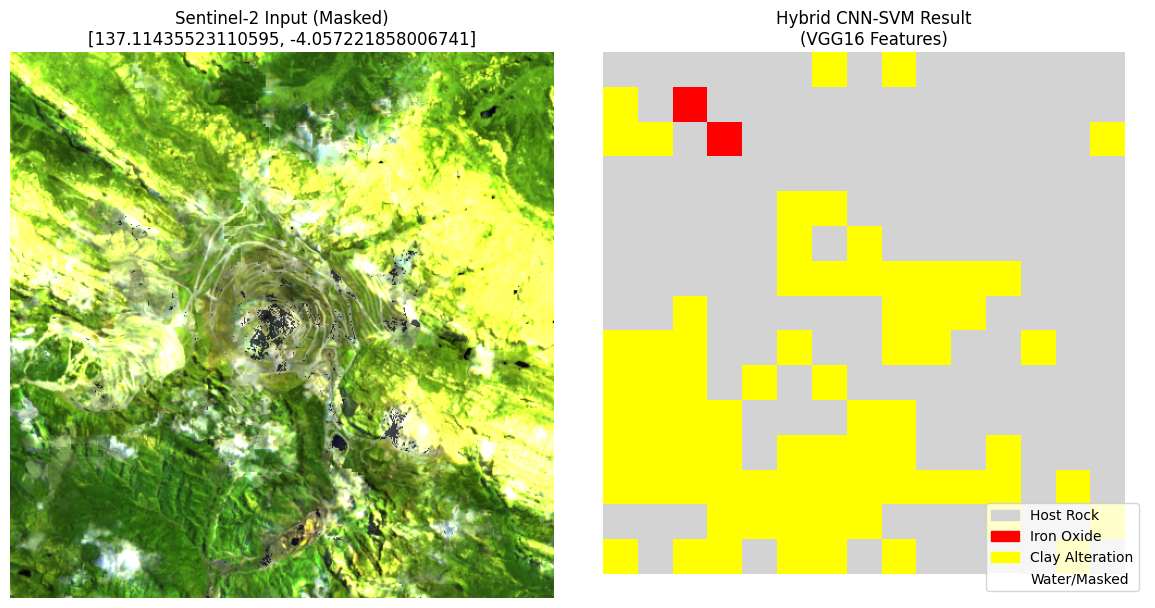

In [13]:
# Create empty result map (initialized to NaN for transparency/masking)
result_map = np.full((H, W), np.nan)

# Fill in predictions
for (y, x), pred in zip(coords, predictions):
    result_map[y:y+PATCH_SIZE, x:x+PATCH_SIZE] = pred

# Plotting using Matplotlib (Local Map)
plt.figure(figsize=(12, 6))

# Subplot 1: Sentinel-2 Input (Land Masked)
plt.subplot(1, 2, 1)
disp_img = img_scaled.astype(float) / 255.0
# Apply land mask to display (dimming water)
mask_3d = np.stack([land_mask]*3, axis=2)
disp_img = np.where(mask_3d, disp_img, disp_img * 0.3)
plt.imshow(disp_img)
plt.title(f"Sentinel-2 Input (Masked)\n{center_point.getInfo()['coordinates']}")
plt.axis('off')

# Subplot 2: SVM Classification
plt.subplot(1, 2, 2)
# Define Colors: 0=Gray, 1=Red, 2=Yellow
# We use a masked array to hide water/background
cmap = plt.cm.colors.ListedColormap(['lightgray', 'red', 'yellow'])
bounds = [-0.5, 0.5, 1.5, 2.5]
norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)

plt.imshow(result_map, cmap=cmap, norm=norm, interpolation='nearest')
plt.title(f"Hybrid CNN-SVM Result\n(VGG16 Features)")
plt.axis('off')

# Custom Legend
patches_leg = [
    mpatches.Patch(color='lightgray', label='Host Rock'),
    mpatches.Patch(color='red', label='Iron Oxide'),
    mpatches.Patch(color='yellow', label='Clay Alteration'),
    mpatches.Patch(color='white', label='Water/Masked')
]
plt.legend(handles=patches_leg, loc='lower right')

plt.tight_layout()
plt.savefig('hybrid_geology_map_masked.png')
print("Processing Complete. Saved 'hybrid_geology_map_masked.png'.")

# The 'else' block from the original code was removed as it was causing an indentation error
# if there were no patches, the `predictions` would be an empty array anyway, resulting in an empty `result_map`.
# The problem of no valid land patches was addressed by ensuring `predictions` is always defined.


# EXPORT

In [ ]:
print("Map generated. Saving to 'geological_map.html'.")
Map.save('geological_map.html')

print("Script complete. Open 'geological_map.html' to view the interactive map.")
print("The ASTER layers use archival data (2000-2008) to ensure high-quality SWIR mineralogy.")
print("RF Classification added using weak supervision from spectral indices.")

Map generated. Saving to 'geological_map.html'.
Script complete. Open 'geological_map.html' to view the interactive map.
The ASTER layers use archival data (2000-2008) to ensure high-quality SWIR mineralogy.


## Export Geological Layers to TIFF


In [ ]:
export_folder = 'Geological_Maps_Export'
print(f"GeoTIFFs will be exported to Google Drive folder: '{export_folder}'")

GeoTIFFs will be exported to Google Drive folder: 'Geological_Maps_Export'


In [ ]:
task_s2_true_color = ee.batch.Export.image.toDrive(
    image=s2_image.select(['B4', 'B3', 'B2']),
    description='S2_TrueColor',
    folder=export_folder,
    fileNamePrefix='S2_TrueColor',
    region=roi,
    scale=10,
    crs='EPSG:4326',
    maxPixels=1e13
)
task_s2_true_color.start()
print(f"Export task 'S2_TrueColor' started. Monitor in GEE Tasks tab: https://code.earthengine.google.com/tasks")

Export task 'S2_TrueColor' started. Monitor in GEE Tasks tab: https://code.earthengine.google.com/tasks


In [ ]:
task_s2_alteration_fcc = ee.batch.Export.image.toDrive(
    image=s2_image.select(['B12', 'B11', 'B2']),
    description='S2_Alteration_FCC',
    folder=export_folder,
    fileNamePrefix='S2_Alteration_FCC',
    region=roi,
    scale=10,
    crs='EPSG:4326',
    maxPixels=1e13
)
task_s2_alteration_fcc.start()
print(f"Export task 'S2_Alteration_FCC' started. Monitor in GEE Tasks tab: https://code.earthengine.google.com/tasks")

Export task 'S2_Alteration_FCC' started. Monitor in GEE Tasks tab: https://code.earthengine.google.com/tasks


In [ ]:
task_s2_iron_oxide_index = ee.batch.Export.image.toDrive(
    image=iron_oxide_idx,
    description='S2_IronOxide_Index',
    folder=export_folder,
    fileNamePrefix='S2_IronOxide_Index',
    region=roi,
    scale=10,
    crs='EPSG:4326',
    maxPixels=1e13
)
task_s2_iron_oxide_index.start()
print(f"Export task 'S2_IronOxide_Index' started. Monitor in GEE Tasks tab: https://code.earthengine.google.com/tasks")

Export task 'S2_IronOxide_Index' started. Monitor in GEE Tasks tab: https://code.earthengine.google.com/tasks


In [ ]:
task_s2_structural_base = ee.batch.Export.image.toDrive(
    image=s2_image.select(['B8']),
    description='S2_Structural_Base',
    folder=export_folder,
    fileNamePrefix='S2_Structural_Base',
    region=roi,
    scale=10,
    crs='EPSG:4326',
    maxPixels=1e13
)
task_s2_structural_base.start()
print(f"Export task 'S2_Structural_Base' started. Monitor in GEE Tasks tab: https://code.earthengine.google.com/tasks")

Export task 'S2_Structural_Base' started. Monitor in GEE Tasks tab: https://code.earthengine.google.com/tasks


In [ ]:
if aster_image is not None:
    task_aster_kaolinite_index = ee.batch.Export.image.toDrive(
        image=kaolinite_idx,
        description='ASTER_Kaolinite_Index',
        folder=export_folder,
        fileNamePrefix='ASTER_Kaolinite_Index',
        region=roi,
        scale=10,
        crs='EPSG:4326',
        maxPixels=1e13
    )
    task_aster_kaolinite_index.start()
    print(f"Export task 'ASTER_Kaolinite_Index' started. Monitor in GEE Tasks tab: https://code.earthengine.google.com/tasks")
else:
    print("ASTER Kaolinite Index not exported: No ASTER images were found for the specified criteria.")

Export task 'ASTER_Kaolinite_Index' started. Monitor in GEE Tasks tab: https://code.earthengine.google.com/tasks


In [ ]:
if aster_image is not None:
    task_aster_alunite_index = ee.batch.Export.image.toDrive(
        image=alunite_idx,
        description='ASTER_Kaolinite_Index',
        folder=export_folder,
        fileNamePrefix='ASTER_Kaolinite_Index',
        region=roi,
        scale=10,
        crs='EPSG:4326',
        maxPixels=1e13
    )
    task_aster_kaolinite_index.start()
    print(f"Export task 'ASTER_Alunite_Index' started. Monitor in GEE Tasks tab: https://code.earthengine.google.com/tasks")
else:
    print("ASTER Alunite Index not exported: No ASTER images were found for the specified criteria.")

In [ ]:
if aster_image is not None:
    task_aster_propylitic_index = ee.batch.Export.image.toDrive(
        image=propylitic_idx,
        description='ASTER_Propylitic_Index',
        folder=export_folder,
        fileNamePrefix='ASTER_Propylitic_Index',
        region=roi,
        scale=10,
        crs='EPSG:4326',
        maxPixels=1e13
    )
    task_aster_propylitic_index.start()
    print(f"Export task 'ASTER_Propylitic_Index' started. Monitor in GEE Tasks tab: https://code.earthengine.google.com/tasks")
else:
    print("ASTER Propylitic Index not exported: No ASTER images were found for the specified criteria.")

Export task 'ASTER_Propylitic_Index' started. Monitor in GEE Tasks tab: https://code.earthengine.google.com/tasks


In [ ]:
task_rf_classification = ee.batch.Export.image.toDrive(
    image=rf_classification,
    description='RF_Classification',
    folder=export_folder,
    fileNamePrefix='RF_Classification',
    region=roi,
    scale=10,
    crs='EPSG:4326',
    maxPixels=1e13
)
task_rf_classification.start()
print(f"Export task 'RF_Classification' started. Monitor in GEE Tasks tab: https://code.earthengine.google.com/tasks")

Export task 'RF_Classification' started. Monitor in GEE Tasks tab: https://code.earthengine.google.com/tasks
